<a href="https://colab.research.google.com/github/YogithL/Data-Science/blob/main/Yogi_LogaU7proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/pydata/xarray.git
!pip install bambi
!pip install preliz
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
import bambi as bmb
import preliz as pz



  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-zjgzjc9_
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-zjgzjc9_
  Resolved https://github.com/pydata/xarray.git to commit 0184702f16c3f744fc9096c7dac690626dcc6922
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for xarray: filename=xarray-2025.1.3.dev22+g0184702f-py3-none-any.whl size=1262235 sha256=137b8af9f86ff4e607fd24ddc66f71bfd9219515264631ffb13742d383b172d5
  Stored in directory: /tmp/pip-ephem-wheel-cache-v3r1se67/wheels/15/f9/46/ac58ec95d7761bd0b92f54d99c5d132719866f63745c3702ed
Successfully built xarray
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.1.2
    Uninstalling xarray-2025.1.2:
      Successfully uninstalled xarray-2025.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 2.6 MB/s eta 0:00:00
   ━

# **Forecasting Fashion Marketing: Predicting Advertising Spending as a Share of GDP**


Every billboard, magazine spread, and influencer promotion comes at a cost, but how much does the fashion industry really spend to stay in the spotlight? With this project, I set out to model and visualize the share of the US GDP dedicated to advertise clothing. Given the country's massive 27 trillion dollar GDP, I expect the percentage to be relatively low.

## **The Data and Visualizations**

In [2]:
adGDP = pd.read_csv('https://raw.githubusercontent.com/YogithL/Data-Science/refs/heads/main/Unit%207%20Data%20Science%20Data%20-%20Sheet1.csv')
adGDP

,year,sales_b,price_index,sales_index,pop_m,realgdp_b,ad_gdppct
0,1929,9.0,27.859,32.306,121.77,1056.6,2.8
1,1930,7.8,26.591,29.333,123.08,966.7,2.7
2,1931,6.7,23.231,28.841,124.04,904.8,2.7
3,1932,4.9,19.081,25.680,124.84,788.2,2.8
4,1933,4.5,19.446,23.141,125.58,778.3,2.3
...,...,...,...,...,...,...,...
80,2009,306.5,100.000,306.500,306.77,14418.7,2.6
81,2010,320.6,99.347,322.707,309.33,14783.8,2.6
82,2011,338.9,101.089,335.249,311.59,15020.6,2.6
83,2012,353.7,104.744,337.680,313.91,15369.2,2.6


In [3]:
#Only keeping the 2 columns we need
adGDP= adGDP[["year", "ad_gdppct"]]

<Axes: xlabel='year', ylabel='ad_gdppct'>

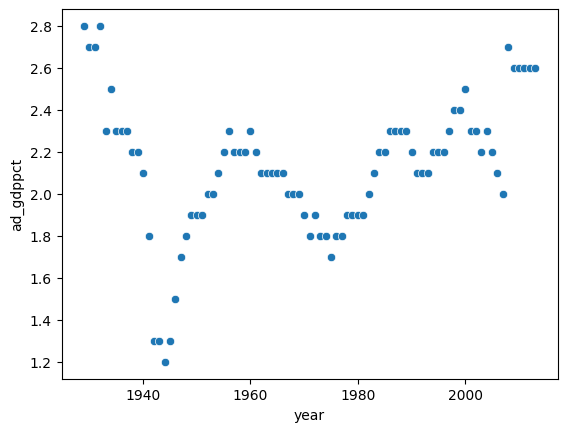

In [4]:
sns.scatterplot(data= adGDP, x= "year", y= "ad_gdppct")

Apart from the actual range of percentages---which was a lot higher than I expected---the overall trend's align with historical events. During WW2, the fashion advertising GDP percentage hit an all-time low, likely due to material shortages. From there, it rebounded steadily into the 1960s before declining again during the Cold War. The trend then shifted upward, until what I think is the 2008 financial crisis.

## **Creating the HSGPs Model: Attempt #1**

In [5]:
#converting pandas to numpy arrays
ad_gdppct = adGDP["ad_gdppct"].values
year = adGDP["year"].values[:,None]


In [6]:
#Returns a weakly informative prior for the length-scale parameter of the GP kernel.
def get_ig_params(x_vals, l_b=None, u_b=None, mass=0.96, plot=False):

    differences = np.abs(np.subtract.outer(x_vals, x_vals))
    if l_b is None:
        l_b = np.min(differences[differences != 0]) * 2
    if u_b is None:
        u_b = np.max(differences) / 1.5

    dist = pz.InverseGamma()
    pz.maxent(dist, l_b, u_b, mass, plot=plot)

    return dict(zip(dist.param_names, dist.params))

In [7]:
prior_gp = {
    #Variance prior
    "sigma": bmb.Prior("Gamma", mu=1, sigma=0.01),
    #Smoothness prior
    "ell": bmb.Prior("InverseGamma", **get_ig_params(year))
}

priors = {
    "hsgp(year, m=10, c=1.5)": prior_gp,
    #Weakly informative ensuring positive values
    "alpha": bmb.Prior("HalfNormal", sigma=1)
}

model_gp1 = bmb.Model("ad_gdppct ~ 0 + hsgp(year, m=10, c=1.5)", adGDP, family="negativebinomial", priors=priors)
idata_gp1 = model_gp1.fit()


Output()

ERROR:pymc.stats.convergence:There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


Although the model has over 20 divergences, sometimes the approximations are still fairly accurate so I'll graph the posterior predictive plot first.

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


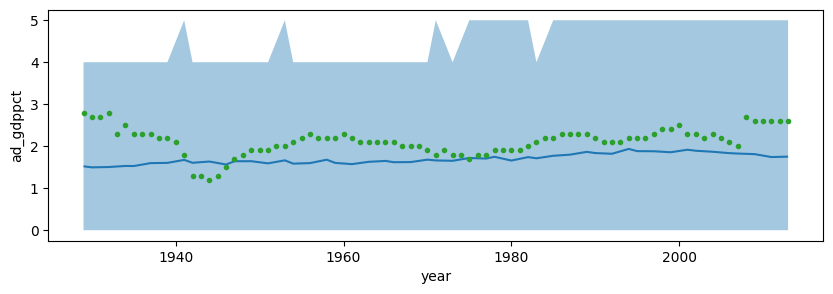

In [8]:
_, ax = bmb.interpret.plot_predictions(model_gp1, idata_gp1, ["year"],
                                       pps = True,
                                       fig_kwargs={"figsize": (10, 3)})
ax[0].plot(adGDP["year"].values, adGDP["ad_gdppct"].values, "C2.")


The first thing I've noticed is that the prediction appears to be extremely linear, which is a stark contrast with the scatterplot. My initial guess is that the weakly informative prior function may have failed, resulting in an ℓ value that's too small compared to the smallest difference between our years (i.e. 1). This could have caused the GP to draw straight lines between the data points rather than capturing the actual pattern. For my second attempt, I'll manually specify the bounds to debug any potential errors with the function.

## **Creating the HSGPs Model: Attempt #2**

In [9]:
#Since the lowest difference between 2 years would be 1
lb=1

#Since the greatest difference between 2 years would be 1
ub=1

In [10]:
prior_gp = {
    #Variance prior
    "sigma": bmb.Prior("Gamma", mu=1, sigma=0.01),
    #Smoothness prior, adding our manual bounds. I also changed the distribution to Uniform since the lb and ub are the same?
    "ell": bmb.Prior("Uniform", lower=lb, upper= ub)
}

priors = {
    "hsgp(year, m=10, c=1.5)": prior_gp,
    #Weakly informative ensuring positive values
    "alpha": bmb.Prior("HalfNormal", sigma=1)
}

model_gp2 = bmb.Model("ad_gdppct ~ 0 + hsgp(year, m=10, c=1.5)", adGDP, family="negativebinomial", priors=priors)
idata_gp2 = model_gp2.fit()

/usr/local/lib/python3.11/dist-packages/pytensor/tensor/rewriting/math.py:2481: RuntimeWarning: invalid value encountered in add
  v = reduce(np.add, num, zero) - reduce(np.add, denum, zero)


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'alpha_log__': array(0.86153245), 'hsgp(year, m=10, c=1.5)_sigma_log__': array(-0.02643958), 'hsgp(year, m=10, c=1.5)_ell_interval__': array(nan), 'hsgp(year, m=10, c=1.5)_weights_raw': array([-0.83661701,  0.74860363,  0.35527538, -0.13043247, -0.11673543,
        0.6267655 , -0.27962531, -0.36733309,  0.3576531 , -0.24715908])}

Logp initial evaluation results:
{'alpha': -2.17, 'hsgp(year, m=10, c=1.5)_sigma': 0.22, 'hsgp(year, m=10, c=1.5)_ell': nan, 'hsgp(year, m=10, c=1.5)_weights_raw': -10.3, 'ad_gdppct': -150.19}
You can call `model.debug()` for more details.

While I was trying to debug the error related to me manually changing the parameters for ℓ, I found a much bigger problem. I had mistakenly used the default **NegativeBinomial** family for creating my model; since, my data isn't discrete, this has major impacts! To solve this, I created a new model using the **Gaussian** distriubtion, a likelihood better suited to handle continuous data.

## **Creating the HSGPs Model: Attempt #3**

In [11]:
prior_gp = {
    "sigma": bmb.Prior("Gamma", mu=1, sigma=0.01),
    "ell": bmb.Prior("InverseGamma", **get_ig_params(year))
}

priors = {
    "hsgp(year, m=10, c=1.5)": prior_gp,
    "alpha": bmb.Prior("HalfNormal", sigma=1)
}

#Changed "negativebinomial" to "gaussian"
model_hsb = bmb.Model("ad_gdppct ~ 0 + hsgp(year, m=10, c=1.5)", adGDP, family="gaussian", priors=priors)
idata_hsb = model_hsb.fit()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


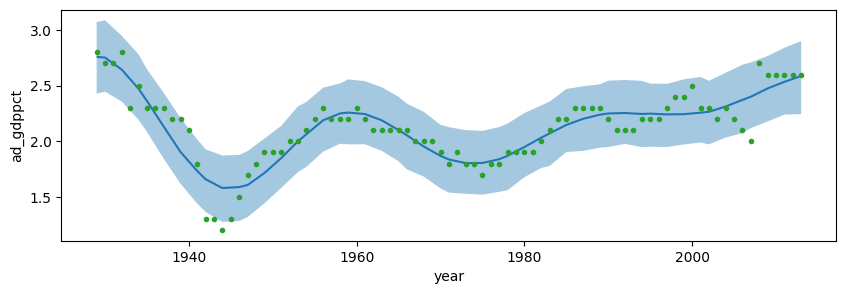

In [12]:
_, ax = bmb.interpret.plot_predictions(model_hsb, idata_hsb, ["year"],
                                       pps = True,
                                       fig_kwargs={"figsize": (10, 3)})
ax[0].plot(adGDP["year"].values, adGDP["ad_gdppct"].values, "C2.")

This new model is one of the best fits I've had for any one of my projects. However, it does fail to account for minor details: the first dip isn't extreme enough and it misses the last 2 dips.

## **Conclusion**

At first, I thought the issue was with the bounds for ℓ, but after a closer look, it was obvious that the problem was a lot simpler. After replacing my likelihood to one that suited continuous data , my model became extremely accurate in predicting the share of the GDP spent on fashion advertising.

If I had more time, I'd like to explore applying GP's for stock forecasting since they seem to handle time series and temporal data generally better. Additionally, I think building the model would be much faster compared to using autoregression since I don't need to invest lots of time constructing temporal matrices.